In [28]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Parsing the incredibly hard to parse LDNe output

The output is a mixture of different lengths whitespaces and symbols, and so requires some parsing....

In [5]:
phase3ldne_list = pd.read_csv("../data/Phase3.LDNe.list")
collections = phase3ldne_list['pop']
phase3ldne_list.shape

(63, 1)

In [6]:
phase3ldne_list.head()

,pop
0,AG1000G-AO.Luanda.2009.coluzzii
1,AG1000G-BF-A.Bana.2012.coluzzii
2,AG1000G-BF-A.Bana.2012.gambiae
3,AG1000G-BF-A.Pala.2012.coluzzii
4,AG1000G-BF-A.Pala.2012.gambiae


In [7]:
chroms = ['2L', '2R','3L', '3R', 'X']

Ne_Ag = dict()
Ne_chrom = dict()

for name in collections:
    for chrom in chroms:
        df = pd.read_csv(f"LDNe/Ag_LDNe_{name}.{chrom}.out", header=None, sep='\n')
        df = df[0].str.split('\s\=\s', expand=True) #split first column using equal sign
        df.columns = ['one', 'two']
        start = np.where(df.one.str.contains('Harmonic Mean'))[0][0] #find start of results
        end = len(df)-3
        df = df.iloc[start:end]                                           #subset 
        
        #loop through rows and remove multiple whitespaces to one whitespace only, then split to new columns
        res=pd.DataFrame()
        for i in range(5):
            results = ' '.join(df.iloc[i,1].split()).split()
            res = res.append(pd.Series(results),ignore_index=True)
        
        #get columns which have estimates for CIs (poorly parsed)
        df2 = df.iloc[6:9,]
        jack = df.iloc[9,0]
        df2.one = df2.one.str.replace("*", "")
        df2 = df2.one.str.split(expand=True).reset_index(drop=True)
        
        #loop through rows and remove multiple whitespaces to one whitespace only, then split to new columns
        for i in range(len(df2)):
            df2.iloc[i,0] = ' '.join(df2.iloc[i,0].split())
        
        #extract specific estimates,works only because all files are parsed identically, not ideal
        para_1 = df2.loc[0,1:4]
        para_2 = df2.loc[1,0:3]
        jack_1 = df2.loc[2,3:7]
        jack_2 = pd.Series(jack.split())
        cols = df.iloc[:5]['one']
        cols = cols.append(pd.Series(['Parametric CI - lower', 
                              'Parametric CI - upper', 
                              'Jackknife CI - lower', 
                              'Jackknife CI - upper']), ignore_index=True)
        
        #append the  estimates to the results 
        df = res.append(para_1.reset_index(drop=True)).append(para_2.reset_index(drop=True)).append(jack_1.reset_index(drop=True)).append(jack_2, ignore_index=True)
        
        #join results to the parameter column and change column names 
        final_results = pd.concat([cols,df], axis=1)
        final_results.columns = ['Parameter', 
                         'minAF_0.05', 
                         'minAF_0.02', 
                         'minAF_0.01', 
                         'minAF_0+']
        
        #store results in dict and then save within nested dict
        Ne_chrom[chrom] = final_results.iloc[:,:2] ### .iloc[:,:2] for 1 allele frequency only!
        
    Ne_Ag[name] = dict(Ne_chrom)

/home/sanj/apps/anaconda3/envs/NeAg/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
Ne = pd.DataFrame()

# transpose, add population and chromosome columns, then re-order columns, and combine all tables for each
# pop into one big one
for name in collections:
    for chrom in chroms:
        
        Ne_Ag[name][chrom] = Ne_Ag[name][chrom].set_index('Parameter').T
        
        Ne_Ag[name][chrom]['name'] = name
        Ne_Ag[name][chrom]['chrom'] = chrom

                # get a list of columns
        cols = list(Ne_Ag[name][chrom])
        # move the column to head of list using index, pop and insert
        cols.insert(0, cols.pop(cols.index('name')))
        Ne_Ag[name][chrom] = Ne_Ag[name][chrom].loc[:, cols]
        cols = list(Ne_Ag[name][chrom])
        cols.insert(0, cols.pop(cols.index('chrom')))
        Ne_Ag[name][chrom] = Ne_Ag[name][chrom].loc[:, cols]
        Ne_Ag[name][chrom]
        
        Ne = pd.concat([Ne, Ne_Ag[name][chrom]])

#change names removing whitespace
Ne.columns = ['chrom', 'pop', 'sample_size', 'independent_comparisons', 
                      'overall_r^2', 'expected_r^2', 'Ne_estimate', 'Parametric_CI_lower',
                     'Parametric_CI_upper', 'Jackknife_CI_lower', 'Jackknife_CI_upper']

### Write to txt file

In [38]:
Ne.to_csv("Ne_analyses.LDNe.tsv", sep="\t", header=True, index=True, index_label='AF')

### Loading metadata

Now, lets add in all the metadata for each population, so that we can plot this on a map.

In [39]:
manifest = pd.read_csv("../../data/phase3/Ag1000g.phase3.manifest.full.tsv", sep="\t")
manifest.location = [loc.replace(" ", "") for loc in manifest.location]
manifest['pop'] = manifest[['sample_set', 'location','year', 'species_gambiae_coluzzii']].astype(str).apply('.'.join, axis=1)

We need to summarise the full manifest - essentially we want metadata info for each distinct collection we are running LDNe on, but also want AIMs and lat long info, for plotting. We first aggregate `manifest` and get the means of AIMS and long/lats, and then separately run size() on `manifest` and assign that to our new df, `manifest_summary`.

With this df, we can join the LDNe results and that will contain all we need to plot.

In [40]:
manifest_summary = manifest.groupby(['pop', 'sample_set', 'country', 'year', 'location', 'species_gambiae_coluzzii']).agg('mean').drop(columns='month').reset_index()
manifest_summary['counts'] = manifest.groupby(['pop', 'sample_set', 'year', 'location', 'species_gambiae_coluzzii']).size().reset_index(name='counts').counts

Lets write the list of pops with n > 15 to .tsv, `Phase3.LDNe.list`, so we have a list of the pops.

In [41]:
#manifest_summary[manifest_summary.counts > 8]['pop'].to_csv("../data/Phase3.LDNe.list", index=None)

In [42]:
new_manifest= manifest_summary[manifest_summary.counts > 8]

In [43]:
Ne_manifest = new_manifest.merge(Ne)

In [45]:
Ne_manifest.to_csv("Ne_manifest.tsv", sep="\t", index=None)

In [224]:
Ne_manifest = pd.read_csv("Ne_manifest.tsv", sep="\t")
Ne_manifest[Ne_manifest.species_gambiae_coluzzii == 'arabiensis']

,pop,sample_set,country,year,location,species_gambiae_coluzzii,latitude,longitude,aim_fraction_colu,aim_fraction_arab,...,chrom,sample_size,independent_comparisons,overall_r^2,expected_r^2,Ne_estimate,Parametric_CI_lower,Parametric_CI_upper,Jackknife_CI_lower,Jackknife_CI_upper
180,AG1000G-KE.Kilifi.2012.arabiensis,AG1000G-KE,Kenya,2012,Kilifi,arabiensis,-3.511,39.909,0.455200,0.742300,...,2L,10.0,81568090,0.137220,0.136900,960.3,848.5,1106.0,107.7,Infinite
181,AG1000G-KE.Kilifi.2012.arabiensis,AG1000G-KE,Kenya,2012,Kilifi,arabiensis,-3.511,39.909,0.455200,0.742300,...,2R,10.0,123299565,0.139108,0.136900,137.8,135.6,140.0,67.3,30665.3
182,AG1000G-KE.Kilifi.2012.arabiensis,AG1000G-KE,Kenya,2012,Kilifi,arabiensis,-3.511,39.909,0.455200,0.742300,...,3L,10.0,124890747,0.137690,0.136900,388.2,372.1,405.9,67.8,Infinite
206,AG1000G-MW.Chikhwawa.2015.arabiensis,AG1000G-MW,Malawi,2015,Chikhwawa,arabiensis,-15.933,34.755,0.455293,0.745098,...,2L,41.0,86756909,0.026421,0.026288,2511.8,2371.0,2670.2,1771.4,4303.2
207,AG1000G-MW.Chikhwawa.2015.arabiensis,AG1000G-MW,Malawi,2015,Chikhwawa,arabiensis,-15.933,34.755,0.455293,0.745098,...,2R,41.0,131049323,0.028867,0.026288,127.1,126.8,127.5,101.0,168.9
208,AG1000G-MW.Chikhwawa.2015.arabiensis,AG1000G-MW,Malawi,2015,Chikhwawa,arabiensis,-15.933,34.755,0.455293,0.745098,...,3L,41.0,130015251,0.026310,0.026288,15134.5,11727.4,21327.7,5795.4,Infinite
214,AG1000G-TZ.Moshi.2012.arabiensis,AG1000G-TZ,Tanzania,2012,Moshi,arabiensis,-3.482,37.308,0.457675,0.750250,...,2L,40.0,89826389,0.027078,0.026994,3974.9,3631.6,4389.8,2441.9,10616.0
215,AG1000G-TZ.Moshi.2012.arabiensis,AG1000G-TZ,Tanzania,2012,Moshi,arabiensis,-3.482,37.308,0.457675,0.750250,...,2R,40.0,131243679,0.030458,0.026994,94.1,93.9,94.3,73.1,129.1
216,AG1000G-TZ.Moshi.2012.arabiensis,AG1000G-TZ,Tanzania,2012,Moshi,arabiensis,-3.482,37.308,0.457675,0.750250,...,3L,40.0,135226577,0.027064,0.026994,4744.8,4345.3,5224.9,2859.1,13851.2
217,AG1000G-TZ.Moshi.2012.arabiensis,AG1000G-TZ,Tanzania,2012,Moshi,arabiensis,-3.482,37.308,0.457675,0.750250,...,3R,40.0,134503905,0.029887,0.026994,113.1,112.8,113.4,67.0,291.6


### Plotting different chromosomes

In [68]:
Ne = Ne_manifest[Ne_manifest.Ne_estimate == 'Infinite']
Ne = Ne[Ne.species_gambiae_coluzzii != 'intermediate']
Ne['Ne_estimate'] = Ne['Ne_estimate'].astype(float)

/home/sanj/apps/anaconda3/envs/NeAg/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [217]:
counts = pd.DataFrame(Ne.groupby(['chrom', 'species_gambiae_coluzzii']).size())

counts.reset_index(inplace=True)
counts.columns = ['chrom', 'species_gambiae_coluzzii', 'n_obs']

order = [ 'coluzzii', 'gambiae', 'arabiensis']

counts['species_gambiae_coluzzii'] = pd.Categorical(counts['species_gambiae_coluzzii'], order)
counts = counts.sort_values(['chrom', 'species_gambiae_coluzzii'])
counts.head()

,chrom,species_gambiae_coluzzii,n_obs
1,2L,coluzzii,12
2,2L,gambiae,34
0,2L,arabiensis,6
4,2R,coluzzii,15
5,2R,gambiae,33


In [218]:
nobs = counts.n_obs
nobs = nobs.append(pd.Series(['0'])).astype(str).tolist()
nobs

['12',
 '34',
 '6',
 '15',
 '33',
 '6',
 '8',
 '29',
 '6',
 '7',
 '29',
 '4',
 '10',
 '28',
 '0']

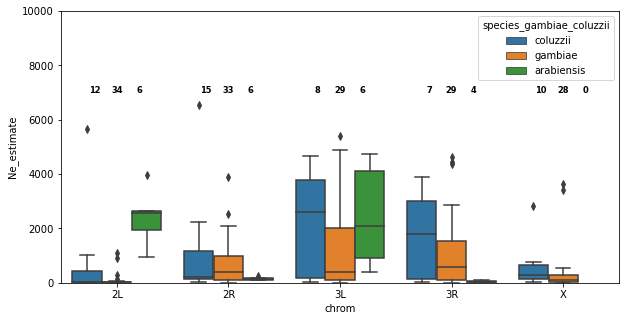

In [221]:
plt.figure(figsize=(10, 5))
plt.ylim(0, 10000)

ax = sns.boxplot(x='chrom', 
            y='Ne_estimate',
            hue='species_gambiae_coluzzii',
            data=Ne, 
            orient="v")

for tick, label in enumerate(ax.get_xticklabels()):
    ax_sex = label.get_text()
    for j, ax_smoker in enumerate(ax.get_legend_handles_labels()[1]):
        x_offset = (j - 1) * 1/5
        num = nobs[((tick*3)+j)]
        ax.text(tick + x_offset, 7000, num,
                horizontalalignment='center', size='small', color='black', weight='semibold')

plt.show()

### Full Table

In [147]:
manifest_summary[manifest_summary.counts > 8].species_gambiae_coluzzii.value_counts()

gambiae         36
coluzzii        16
arabiensis       6
intermediate     5
Name: species_gambiae_coluzzii, dtype: int64

In [220]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(manifest_summary[manifest_summary.counts > 8])

,pop,sample_set,country,year,location,species_gambiae_coluzzii,latitude,longitude,aim_fraction_colu,aim_fraction_arab,counts
0,AG1000G-AO.Luanda.2009.coluzzii,AG1000G-AO,Angola,2009,Luanda,coluzzii,-8.884,13.302,0.937901,0.001136,81
1,AG1000G-BF-A.Bana.2012.coluzzii,AG1000G-BF-A,Burkina Faso,2012,Bana,coluzzii,11.233,-4.472,0.975738,0.002024,42
2,AG1000G-BF-A.Bana.2012.gambiae,AG1000G-BF-A,Burkina Faso,2012,Bana,gambiae,11.233,-4.472,0.035000,0.002455,22
4,AG1000G-BF-A.Pala.2012.coluzzii,AG1000G-BF-A,Burkina Faso,2012,Pala,coluzzii,11.150,-4.235,0.979909,0.002000,11
5,AG1000G-BF-A.Pala.2012.gambiae,AG1000G-BF-A,Burkina Faso,2012,Pala,gambiae,11.150,-4.235,0.027146,0.002146,48
6,AG1000G-BF-A.Souroukoudinga.2012.coluzzii,AG1000G-BF-A,Burkina Faso,2012,Souroukoudinga,coluzzii,11.235,-4.535,0.977276,0.002793,29
7,AG1000G-BF-A.Souroukoudinga.2012.gambiae,AG1000G-BF-A,Burkina Faso,2012,Souroukoudinga,gambiae,11.235,-4.535,0.028071,0.002071,28
9,AG1000G-BF-B.Bana.2014.coluzzii,AG1000G-BF-B,Burkina Faso,2014,Bana,coluzzii,11.233,-4.472,0.977532,0.002149,47
10,AG1000G-BF-B.Bana.2014.gambiae,AG1000G-BF-B,Burkina Faso,2014,Bana,gambiae,11.233,-4.472,0.025867,0.002333,15
12,AG1000G-BF-B.Pala.2014.gambiae,AG1000G-BF-B,Burkina Faso,2014,Pala,gambiae,11.150,-4.235,0.027188,0.002188,16
